seqs input torch.Size([5, 10, 20]) torch.Size([5, 20, 10])
[[ 8.100e-01  1.300e+02  5.880e+00]
 [ 1.190e+00  9.100e+01  5.910e+00]
 [ 2.600e-01  1.070e+02  5.630e+00]
 [ 1.200e-01  4.200e+01  6.300e+00]
 [ 6.400e-01  7.500e+01  5.740e+00]
 [ 1.380e+00  5.700e+01  6.040e+00]
 [ 1.060e+00  5.700e+01  6.040e+00]
 [ 1.080e+00  4.300e+01  6.020e+00]
 [ 6.200e-01  1.500e+01  6.110e+00]
 [ 4.800e-01  1.000e+00  6.060e+00]
 [ 2.900e-01  4.700e+01  5.020e+00]
 [-1.800e-01  3.100e+01  5.680e+00]
 [-5.000e-02  4.500e+01  5.600e+00]
 [-8.500e-01  7.200e+01  5.650e+00]
 [-7.800e-01  5.800e+01  1.076e+01]
 [-9.000e-01  5.900e+01  2.980e+00]
 [-7.400e-01  7.300e+01  3.080e+00]
 [-4.000e-01  8.200e+01  7.640e+00]
 [-2.530e+00  1.010e+02  1.076e+01]
 [-1.500e+00  7.300e+01  9.470e+00]]
[[ 0.7084399   1.         -0.25449871]
 [ 0.9028133   0.39534884 -0.24678663]
 [ 0.42710997  0.64341085 -0.31876607]
 [ 0.35549872 -0.36434109 -0.14652956]
 [ 0.62148338  0.14728682 -0.29048843]
 [ 1.         -0.13178295

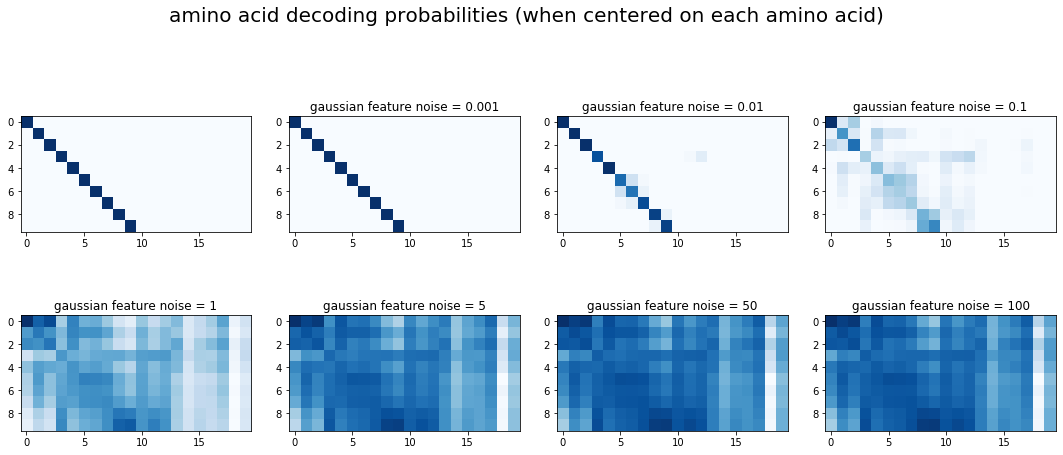

In [37]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
_PI = torch.Tensor([math.pi])

#############################################
# 0. tools for creating gaussian mixtures
def create_gauss(point, cov):
    '''returns parameters according to specified Gaussian.
    Dimension of the gaussian is the number of AA features used.'''
    if len(cov.shape) == 1:
        cov = torch.diag(cov) # no covariation
    n = point.shape[-1] # this is the number of AA features being used, the dimension of the guassian
    Z = ((_PI*2)**(-n/2))*(torch.det(cov)**(-0.5)) # everything before the exponent, normalizing constant
    return point, torch.inverse(cov), Z

def create_gmix(points, covs, props):
    '''takes centers [g x n] & covs [g x n x n] & proportions [g],
    yields centers [g x n] & sigmas [g x n x n] & normalizing terms [g]'''
    g, n = points.shape
    centers, sigs, Zs = torch.zeros((g,n)), torch.zeros((g, n, n)), torch.zeros(g)
    for i in range(len(points)):
        centers[i, :], sigs[i, :, :], Zs[i] = create_gauss(points[i,:], covs[i,:,:])
    Zs = Zs*props # weighting the constants by the proportion.
    return centers, sigs, Zs

#############################################
# 1. create normalized amino acid properties
def center_and_scale(x):
    '''adjusts and scales values to [-1,1]'''
    #TODO: try and have a CDF for the different properties rather than a norm scaling. 
    x_n = x - x.min()
    x_n = x_n / x_n.max()
    x_n = x_n*2 - 1
    return x_n

# 2. create feature encoder and decoder
def aa_to_seq_encoder(aa_prop, features, aa_order='ACDEFGHIKLNMPQRSTVWY'):
    '''the decoder works by creating a dictionary that products w one-hots, given seq [L x a]'''
    aa_features = aa_prop.set_index('aa').loc[list(aa_order), features].values
    
    print(aa_features)
    for c in range(aa_features.shape[1]):
        aa_features[:,c] = center_and_scale(aa_features[:,c])
    print(aa_features)
    
    feat_map = torch.Tensor(aa_features)
    print('feature map', feat_map.shape)
    return lambda seqs: (feat_map.T@seqs.transpose(1,2)).permute(0,2,1)
    #return lambda seq: torch.einsum('bla,ban->bln', seq, feat_map)

def decode_feats_to_seq(x, Cs, sigs, Zs):
    ''' x is a list of continous values we want to map to a log pdf over the AAs. 
    log(p_g) at list of points [L x n], given gaussian mixture
    w/ centers [g x n] & covs [g x n x n] & proportions (normalizing constants) [1 x g]'''
    print( 'decoderrrr', x.shape, Cs.shape)
    d = (x.unsqueeze(2) - Cs.unsqueeze(0).unsqueeze(0))# broadcast [_ x _ x g x n] vs [b x L x _ x n]
    print('d shape', d.shape, 'sigs ', sigs.shape)
    #print(x[0,0,:], Cs, d[0,0,:,:])
    
    #dEd = d.T@sigs.unsqueeze(0)@d
    dE = torch.einsum('blgn,gnm->blgm', d, sigs)
    dEd = torch.einsum('blgn,blgn->blg', d, dE)
    logP = torch.log(Zs) - 0.5*dEd
    return logP - torch.logsumexp(logP, dim=2).unsqueeze(2) # normalizes the probabilities of each. 

#############################################   
# Wrap it all together -- initialize this during model initialization- not inside 'forward'
def initialize_aa(AA_FILE, seqlen, noise=0.1, aa_order='ACDEFGHIKLNMPQRSTVWY'):
    '''creates encoder and decoder functions'''
    aaprop = pd.read_csv(AA_FILE)
    feats = ['Hydrophobicity', 'Mass', 'pI']
    n = len(feats)
    encoder = aa_to_seq_encoder(aaprop, feats, aa_order)
    aa_feat_matrix = encoder(torch.eye(20).unsqueeze(0)).squeeze() # need to squeeze and unsqueeze for batching reasons. 
    print('encoded matrix')
    centers, sigs, Zs = create_gmix(
        aa_feat_matrix,
        covs = torch.Tensor([noise*np.eye(n)]*20),
        props=torch.ones(20)/20 )
    #Cs = torch.stack([centers]*seqlen, dim=0) # [L x g x n] # why are we repeating the centers here??? 
    decoder = lambda x: decode_feats_to_seq(x, centers, sigs, Zs)
    return encoder, decoder, centers, sigs
#############################################
# test it out!
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(15, 7)
ax = ax.flatten()
# selecting the first 10 one hot sequences and making a repeat batch of 5 of them. 
s = torch.tensor( [np.eye(20)[:10,:]] *5).float() #torch.Tensor(np.eye(20)).unsqueeze(0)
print('seqs input', s.shape, s.transpose(1,2).shape)
ax[0].imshow(s[2], cmap='Blues')
for i, noise in enumerate([100, 50, 5, 1, 0.1, 0.01, 0.001][::-1]):
    encode, decode, c, sig = initialize_aa('../pytorch/EVCouplingsStuff/amino_acid_properties_full.csv',
        seqlen=20, noise=noise, aa_order='WFYPMILVAGCSTQNDEHRK')
    e_s = encode(s)
    print('encoded shape', e_s.shape)
    res = decode(e_s).exp()[2]
    print(res.shape)
    #print(res)
    ax[i+1].imshow(res, cmap='Blues')
    ax[i+1].set_title('gaussian feature noise = '+str(noise))
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('amino acid decoding probabilities (when centered on each amino acid)', fontsize=20);

In [5]:
c

tensor([[ 8.1000e-01,  1.3000e+02,  5.8800e+00],
        [ 1.1900e+00,  9.1000e+01,  5.9100e+00],
        [ 2.6000e-01,  1.0700e+02,  5.6300e+00],
        [ 1.2000e-01,  4.2000e+01,  6.3000e+00],
        [ 6.4000e-01,  7.5000e+01,  5.7400e+00],
        [ 1.3800e+00,  5.7000e+01,  6.0400e+00],
        [ 1.0600e+00,  5.7000e+01,  6.0400e+00],
        [ 1.0800e+00,  4.3000e+01,  6.0200e+00],
        [ 6.2000e-01,  1.5000e+01,  6.1100e+00],
        [ 4.8000e-01,  1.0000e+00,  6.0600e+00],
        [ 2.9000e-01,  4.7000e+01,  5.0200e+00],
        [-1.8000e-01,  3.1000e+01,  5.6800e+00],
        [-5.0000e-02,  4.5000e+01,  5.6000e+00],
        [-8.5000e-01,  7.2000e+01,  5.6500e+00],
        [-7.8000e-01,  5.8000e+01,  1.0760e+01],
        [-9.0000e-01,  5.9000e+01,  2.9800e+00],
        [-7.4000e-01,  7.3000e+01,  3.0800e+00],
        [-4.0000e-01,  8.2000e+01,  7.6400e+00],
        [-2.5300e+00,  1.0100e+02,  1.0760e+01],
        [-1.5000e+00,  7.3000e+01,  9.4700e+00]])

In [29]:
lol = torch.from_numpy(np.array([0.0,40,5])).unsqueeze(0).unsqueeze(0).float()
lol.shape

torch.Size([1, 1, 3])

In [30]:
probs = np.exp(decode(lol).numpy())
lol = lol.squeeze().numpy()

decoderrrr torch.Size([1, 1, 3]) torch.Size([20, 3])
d shape torch.Size([1, 1, 20, 3]) sigs  torch.Size([20, 3, 3])


In [31]:
lol

array([ 0., 40.,  5.], dtype=float32)

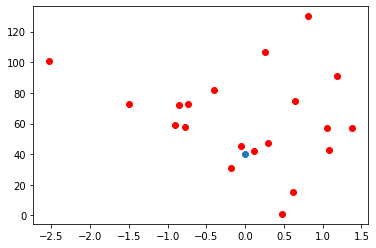

In [32]:
plt.scatter( c[:,0], c[:,1], color='red' )
plt.scatter(lol[0], lol[1])

In [106]:
lol = torch.tensor( [np.eye(20)] *5).float()
feats = torch.randn((20,3))
feats.shape

torch.Size([20, 3])

In [96]:
torch.einsum('la,an->ln', lol[0].squeeze(), feats)

tensor([[-9.9771e-01, -1.9332e+00,  1.0130e+00],
        [-5.9026e-01, -2.9833e-01,  8.8200e-01],
        [ 2.0485e-01, -9.2464e-01,  8.3436e-02],
        [-4.2730e-01,  1.1381e-03,  4.1514e-01],
        [-8.5059e-01, -5.4162e-02, -7.2055e-01],
        [-9.3871e-01, -5.6655e-01, -1.7825e-01],
        [ 4.7686e-01,  2.5839e-04, -9.6617e-01],
        [ 3.2777e-01,  1.5120e-01, -1.0330e+00],
        [-3.5218e-01,  3.5620e-02,  9.6991e-01],
        [-2.8325e-01, -7.0944e-01,  6.5591e-01],
        [ 3.2434e-01,  3.0051e-01, -6.8936e-01],
        [ 2.9958e-01,  1.6838e+00,  5.6566e-01],
        [ 1.0706e+00,  6.1538e-02,  2.2722e+00],
        [-6.2689e-01, -2.7771e-01,  1.0048e+00],
        [-1.7366e-01,  2.0378e-01, -4.2482e-01],
        [ 4.0196e-01,  1.7864e-01, -9.4169e-01],
        [-1.3386e-01,  1.4831e-01, -9.1156e-01],
        [-2.3924e-01,  9.4201e-01,  1.3058e+00],
        [-2.4148e-01, -5.9411e-01, -1.3937e+00],
        [-7.3004e-02, -1.8971e+00, -4.0073e-01]])

In [97]:
(feats.T@lol[0].squeeze()).T.view(20,3)

tensor([[-9.9771e-01, -1.9332e+00,  1.0130e+00],
        [-5.9026e-01, -2.9833e-01,  8.8200e-01],
        [ 2.0485e-01, -9.2464e-01,  8.3436e-02],
        [-4.2730e-01,  1.1381e-03,  4.1514e-01],
        [-8.5059e-01, -5.4162e-02, -7.2055e-01],
        [-9.3871e-01, -5.6655e-01, -1.7825e-01],
        [ 4.7686e-01,  2.5839e-04, -9.6617e-01],
        [ 3.2777e-01,  1.5120e-01, -1.0330e+00],
        [-3.5218e-01,  3.5620e-02,  9.6991e-01],
        [-2.8325e-01, -7.0944e-01,  6.5591e-01],
        [ 3.2434e-01,  3.0051e-01, -6.8936e-01],
        [ 2.9958e-01,  1.6838e+00,  5.6566e-01],
        [ 1.0706e+00,  6.1538e-02,  2.2722e+00],
        [-6.2689e-01, -2.7771e-01,  1.0048e+00],
        [-1.7366e-01,  2.0378e-01, -4.2482e-01],
        [ 4.0196e-01,  1.7864e-01, -9.4169e-01],
        [-1.3386e-01,  1.4831e-01, -9.1156e-01],
        [-2.3924e-01,  9.4201e-01,  1.3058e+00],
        [-2.4148e-01, -5.9411e-01, -1.3937e+00],
        [-7.3004e-02, -1.8971e+00, -4.0073e-01]])

In [98]:
(feats.T@lol).permute(0,2,1)

tensor([[[-9.9771e-01, -1.9332e+00,  1.0130e+00],
         [-5.9026e-01, -2.9833e-01,  8.8200e-01],
         [ 2.0485e-01, -9.2464e-01,  8.3436e-02],
         [-4.2730e-01,  1.1381e-03,  4.1514e-01],
         [-8.5059e-01, -5.4162e-02, -7.2055e-01],
         [-9.3871e-01, -5.6655e-01, -1.7825e-01],
         [ 4.7686e-01,  2.5839e-04, -9.6617e-01],
         [ 3.2777e-01,  1.5120e-01, -1.0330e+00],
         [-3.5218e-01,  3.5620e-02,  9.6991e-01],
         [-2.8325e-01, -7.0944e-01,  6.5591e-01],
         [ 3.2434e-01,  3.0051e-01, -6.8936e-01],
         [ 2.9958e-01,  1.6838e+00,  5.6566e-01],
         [ 1.0706e+00,  6.1538e-02,  2.2722e+00],
         [-6.2689e-01, -2.7771e-01,  1.0048e+00],
         [-1.7366e-01,  2.0378e-01, -4.2482e-01],
         [ 4.0196e-01,  1.7864e-01, -9.4169e-01],
         [-1.3386e-01,  1.4831e-01, -9.1156e-01],
         [-2.3924e-01,  9.4201e-01,  1.3058e+00],
         [-2.4148e-01, -5.9411e-01, -1.3937e+00],
         [-7.3004e-02, -1.8971e+00, -4.0073e-01]],